In [42]:
import pandas as pd
import random
from datetime import datetime, timedelta

def generate_synthetic_data_with_modes(start_date, num_days=14, samples_per_day=24):
    target_temperature = 24.0
    target_humidity = 60.0
    
    modes = {
        "work": {"days": [2], "temperature": target_temperature, "humidity": target_humidity},
        "entertainment": {"days": [5, 6], "temperature": target_temperature + 1, "humidity": target_humidity - 5},
        "relax": {"days": [5, 6], "temperature": target_temperature - 1, "humidity": target_humidity + 5},
        "default": {"temperature": target_temperature - 2, "humidity": target_humidity - 10}
    }
    
    synthetic_data = []
    current_date = pd.to_datetime(start_date)
    
    for _ in range(num_days):
        for i in range(samples_per_day):
            hour = i * (24 // samples_per_day)  
            timestamp = current_date + timedelta(hours=hour)
            day_of_week = timestamp.weekday()  

          
            if day_of_week in modes["work"]["days"]:
                mode = "work"
            elif day_of_week in modes["entertainment"]["days"]:
                mode = "entertainment"
            elif day_of_week in modes["relax"]["days"]:
                mode = "relax"
            else:
                mode = "default"

      
            base_temp = modes[mode]["temperature"]
            base_humidity = modes[mode]["humidity"]

            temperature = round(base_temp + random.uniform(-1.5, 1.5), 2)
            humidity = round(base_humidity + random.uniform(-10, 10), 2)

   
            heater_on = temperature < target_temperature
            humidifier_on = humidity < target_humidity

            
            air_quality = random.choice(["good", "poor"])

            
            synthetic_data.append({
                "timestamp": timestamp,
                "temperature": temperature,
                "humidity": humidity,
                "air_quality": air_quality,
                "work_mode": mode,
                "heater_on": heater_on,
                "humidifier_on": humidifier_on
            })
        
        current_date += timedelta(days=1)
    
    return pd.DataFrame(synthetic_data)

start_date = "2024-01-01"
synthetic_df = generate_synthetic_data_with_modes(start_date, num_days=80, samples_per_day=24)


print(synthetic_df.head())


synthetic_df.to_csv("synthetic_environment_data.csv", index=False)

            timestamp  temperature  humidity air_quality work_mode  heater_on  \
0 2024-01-01 00:00:00        21.95     43.42        good   default       True   
1 2024-01-01 01:00:00        20.70     47.92        good   default       True   
2 2024-01-01 02:00:00        23.47     57.74        good   default       True   
3 2024-01-01 03:00:00        21.89     46.72        poor   default       True   
4 2024-01-01 04:00:00        20.55     45.25        good   default       True   

   humidifier_on  
0           True  
1           True  
2           True  
3           True  
4           True  


In [26]:

synthetic_df['day_of_week'] = synthetic_df['timestamp'].dt.weekday
synthetic_df['hour'] = synthetic_df['timestamp'].dt.hour


mode_mapping = {"work": 0, "entertainment": 1, "relax": 2, "default": 3}
synthetic_df['work_mode_encoded'] = synthetic_df['work_mode'].map(mode_mapping)


features = synthetic_df[["temperature", "humidity", "day_of_week", "hour"]]
target_mode = synthetic_df["work_mode_encoded"]  
target_heater = synthetic_df["heater_on"].astype(int) 
target_humidifier = synthetic_df["humidifier_on"].astype(int)  


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [27]:
import numpy as np

def create_sequences(data, targets, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(targets[i + look_back])
    return np.array(X), np.array(y)

look_back = 10


X_mode, y_mode = create_sequences(features_scaled, target_mode, look_back)


X_heater, y_heater = create_sequences(features_scaled, target_heater, look_back)
X_humidifier, y_humidifier = create_sequences(features_scaled, target_humidifier, look_back)


train_size = int(len(X_mode) * 0.8)

X_mode_train, X_mode_test = X_mode[:train_size], X_mode[train_size:]
y_mode_train, y_mode_test = y_mode[:train_size], y_mode[train_size:]

X_heater_train, X_heater_test = X_heater[:train_size], X_heater[train_size:]
y_heater_train, y_heater_test = y_heater[:train_size], y_heater[train_size:]

X_humidifier_train, X_humidifier_test = X_humidifier[:train_size], X_humidifier[train_size:]
y_humidifier_train, y_humidifier_test = y_humidifier[:train_size], y_humidifier[train_size:]


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

mode_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, X_mode.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(len(mode_mapping), activation="softmax")  # 多分类输出
])

mode_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


mode_model.fit(X_mode_train, y_mode_train, epochs=50, batch_size=32, validation_data=(X_mode_test, y_mode_test))



Epoch 1/50


/Users/wzc/anaconda3/envs/Computational-Mathematics/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6652 - loss: 1.0824 - val_accuracy: 0.8287 - val_loss: 0.5270
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8669 - loss: 0.3951 - val_accuracy: 0.8916 - val_loss: 0.2451
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9155 - loss: 0.2068 - val_accuracy: 0.9336 - val_loss: 0.1500
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9479 - loss: 0.1394 - val_accuracy: 0.9615 - val_loss: 0.1109
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9744 - loss: 0.0831 - val_accuracy: 0.9685 - val_loss: 0.0899
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9735 - loss: 0.0760 - val_accuracy: 0.9755 - val_loss: 0.0784
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9666 - loss: 0.0807 - val_accuracy: 0.9615 - val_loss: 0.1087
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9747 - loss: 0.0630 - val_accuracy: 0.9545 - val_loss: 0.0893
Epo

In [29]:
# 加热器状态模型
heater_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, X_heater.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation="sigmoid")  # 二分类输出
])

heater_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 训练加热器状态模型
heater_model.fit(X_heater_train, y_heater_train, epochs=50, batch_size=32, validation_data=(X_heater_test, y_heater_test))

# 加湿器状态模型
humidifier_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, X_humidifier.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation="sigmoid")  # 二分类输出
])

humidifier_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 训练加湿器状态模型
humidifier_model.fit(X_humidifier_train, y_humidifier_train, epochs=50, batch_size=32, validation_data=(X_humidifier_test, y_humidifier_test))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7233 - loss: 0.5685 - val_accuracy: 0.8322 - val_loss: 0.3827
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8341 - loss: 0.3670 - val_accuracy: 0.8392 - val_loss: 0.3503
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8445 - loss: 0.3354 - val_accuracy: 0.8497 - val_loss: 0.3308
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.2929 - val_accuracy: 0.8531 - val_loss: 0.3311
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8657 - loss: 0.2971 - val_accuracy: 0.8531 - val_loss: 0.3368
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.2814 - val_accuracy: 0.8392 - val_loss: 0.3542
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8624 - loss: 0.2819 - val_accuracy: 0.8566 - val_loss: 0.3391
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8512 - loss: 0.2855 - val_accuracy: 0.8566 - val_loss:

In [30]:
# 模式预测
mode_predictions = mode_model.predict(X_mode_test)
predicted_modes = np.argmax(mode_predictions, axis=1)

# 反向映射模式
mode_mapping_reverse = {v: k for k, v in mode_mapping.items()}
predicted_mode_labels = [mode_mapping_reverse[m] for m in predicted_modes]
print(predicted_mode_labels)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
['entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'entertainment', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'default', 'work', 'work', 'work', 'work', 'work', 'work', 'work

In [31]:
# 加热器状态预测
heater_predictions = heater_model.predict(X_heater_test)
predicted_heater_states = (heater_predictions > 0.5).astype(int)
print(predicted_heater_states)

# 加湿器状态预测
humidifier_predictions = humidifier_model.predict(X_humidifier_test)
predicted_humidifier_states = (humidifier_predictions > 0.5).astype(int)
print(predicted_humidifier_states)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [

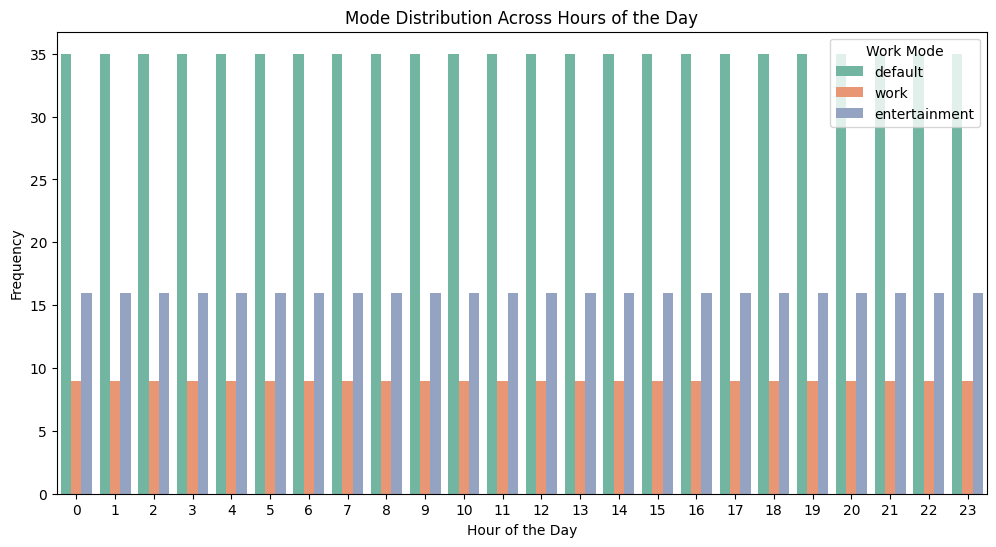

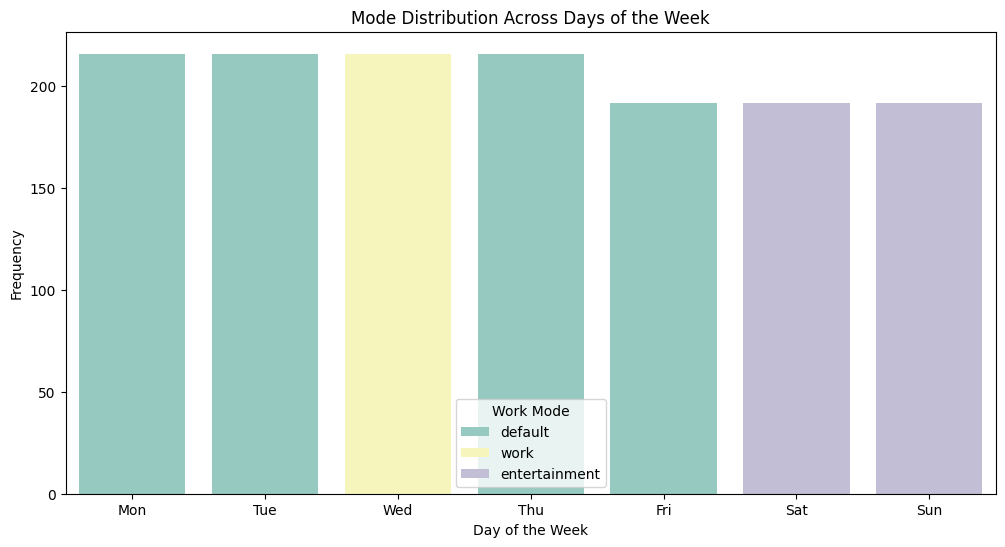

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 模式在一天中的分布
plt.figure(figsize=(12, 6))
sns.countplot(data=synthetic_df, x="hour", hue="work_mode", palette="Set2")
plt.title("Mode Distribution Across Hours of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.legend(title="Work Mode")
plt.show()

# 模式在一周中的分布
plt.figure(figsize=(12, 6))
sns.countplot(data=synthetic_df, x="day_of_week", hue="work_mode", palette="Set3")
plt.title("Mode Distribution Across Days of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Frequency")
plt.legend(title="Work Mode")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()


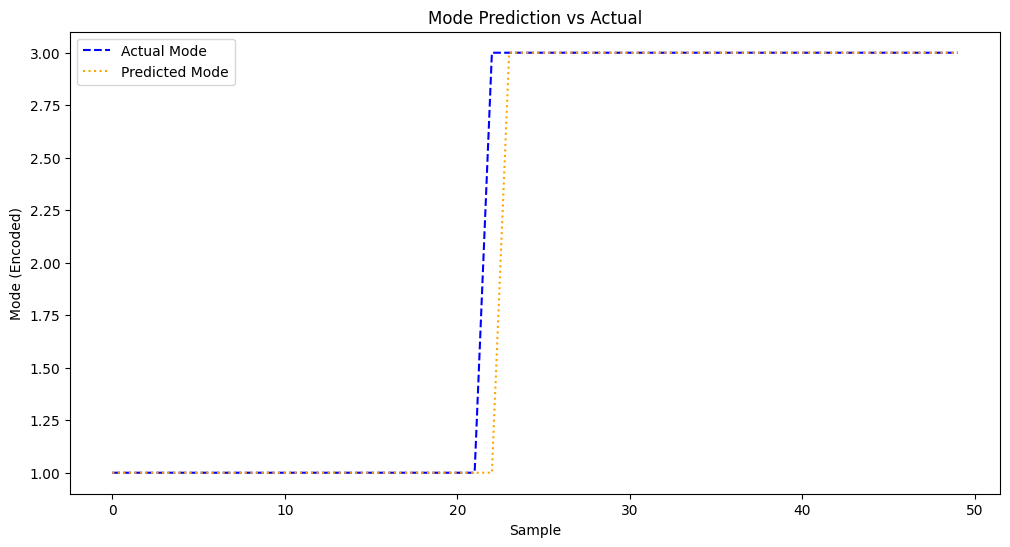

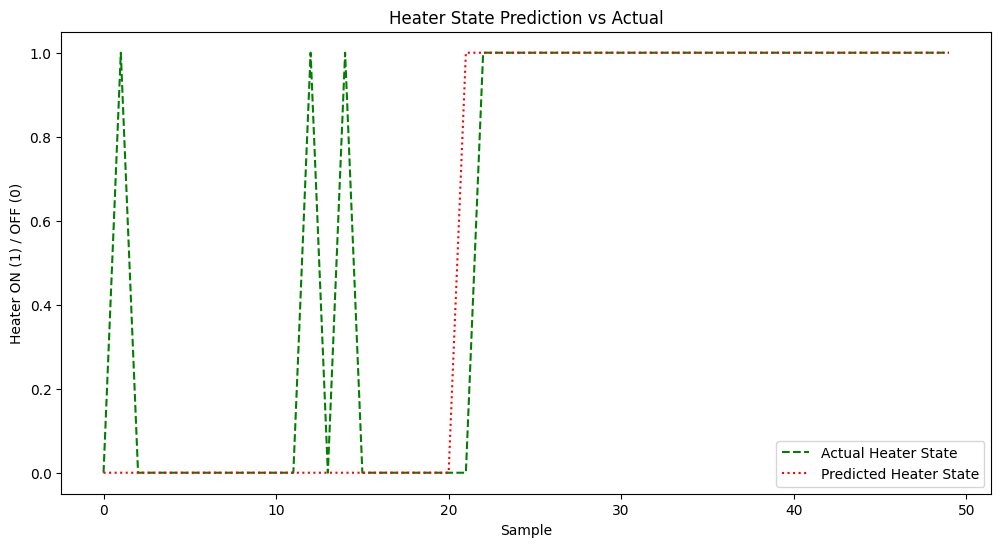

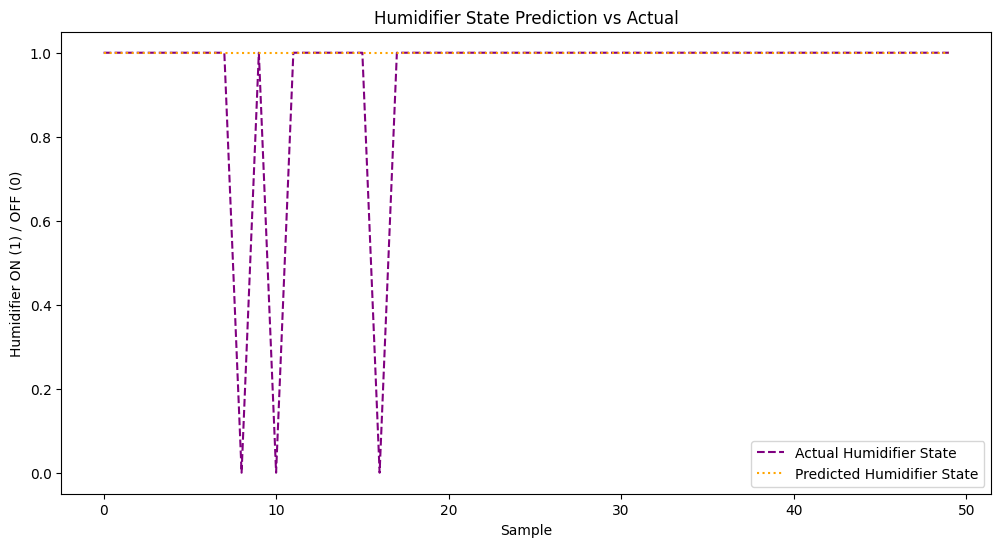

In [33]:
# 模式预测对比
plt.figure(figsize=(12, 6))
plt.plot(y_mode_test[:50], label="Actual Mode", color="blue", linestyle="--")
plt.plot(predicted_modes[:50], label="Predicted Mode", color="orange", linestyle=":")
plt.title("Mode Prediction vs Actual")
plt.xlabel("Sample")
plt.ylabel("Mode (Encoded)")
plt.legend()
plt.show()

# 加热器状态预测对比
plt.figure(figsize=(12, 6))
plt.plot(y_heater_test[:50], label="Actual Heater State", color="green", linestyle="--")
plt.plot(predicted_heater_states[:50], label="Predicted Heater State", color="red", linestyle=":")
plt.title("Heater State Prediction vs Actual")
plt.xlabel("Sample")
plt.ylabel("Heater ON (1) / OFF (0)")
plt.legend()
plt.show()

# 加湿器状态预测对比
plt.figure(figsize=(12, 6))
plt.plot(y_humidifier_test[:50], label="Actual Humidifier State", color="purple", linestyle="--")
plt.plot(predicted_humidifier_states[:50], label="Predicted Humidifier State", color="orange", linestyle=":")
plt.title("Humidifier State Prediction vs Actual")
plt.xlabel("Sample")
plt.ylabel("Humidifier ON (1) / OFF (0)")
plt.legend()
plt.show()
